ranks:  [4.0, 1.0, 2.0, 3.0]
Pearson rank coefficient: 0.27
Spearman rank coefficient: 0.80


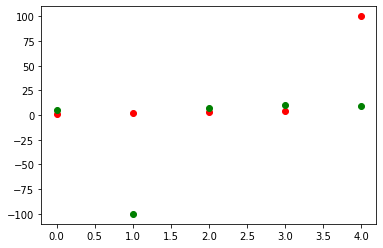

In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

config = pd.Series({
    'devide_by':5
})



# study of skewness of the data population
def skewness(df:pd.DataFrame, column:str):
    """
    Mesures of asymetry: 
    Negative deviation indicates that the destribution skews left. The skewness of a normal distrubtion is zero. And any symetric data must have skewness equal to zero.
    The alternative to this is by lookig into the relationship between the mean and the median.
    """
    assert df[column] is not None
    assert column != ''
    
    result = 0
    series = df[column]
    data_mean = series.mean()
    data_std = series.std()
    data_count = len(series)
    
    for i in series:
        result += ((i - data_mean) * (i - data_mean) * (i - data_mean))
    result /= (data_count * data_std * data_std * data_std)
    
    return result

# Pearson median skewness coefficient
def pearson(df:pd.DataFrame, column:str):
    """
    is an alternative to skewness coefficient
    """
    assert df[column] is not None
    assert column != ''
    
    result = 0
    series = df[column]
    data_mean = series.mean()
    data_median = series.median()
    data_std = series.std()
    data_count = len(series)
    
    result = 3*(data_mean - data_median)*data_std
    
    return result


def get_features_nans(df:pd.DataFrame):
    result = (df.isna().sum()/df.shape[0])*100
    return result[result > 0].to_dict()

def get_features_zero(df:pd.DataFrame):
    result = (df.isin([0]).sum()/df.shape[0])*100
    return result[result > 0].to_dict()

def get_nans_counts(df:pd.DataFrame, column:str, mean_of_column:str, mean_of_value):
    return df[df[mean_of_column] == mean_of_value][column].isna().sum()

def get_columns(df: pd.DataFrame, cat_only:bool=False, num_only:bool=False) -> dict:
    if cat_only:
        cat_col = df.select_dtypes(include=['object']).columns
        return {col:len(set(df[col])) for col in cat_col}
    if num_only:
        num_col = df.select_dtypes(exclude=['object']).columns
        return {col:len(set(df[col])) for col in num_col}
    return {col:len(set(df[col])) for col in df.columns}

def cross_val_evaluation(model,X_train, y_train, model_name):
    scores = cross_val_score(model, X_train, y_train,cv=5) # scoring="neg_root_mean_squared_error"
    print("\n ",model_name)
    display_scores(scores)
    
def calcualte_scores(y, y_hat, show=True):
    ## Evaluate the model and plot it
    mdl_mse = mean_squared_error(y, y_hat)
    mdl_rmse = np.sqrt(mdl_mse)
    mdl_mae = mean_absolute_error(y, y_hat)
    mdl_r2score = r2_score(y, y_hat)
    
    # Best possible score is 1.0, lower values are worse.
    if show:
        print("----- EVALUATION ON VAL SET ------")
        print('MSE:', mdl_mse)
        print('RMSE', mdl_rmse)
        print('MAE:', mdl_mae)
        print('R^2: ', mdl_r2score) 
        print()
        plt.scatter(y, y_hat)
        plt.xlabel('y')
        plt.ylabel('y^')
        plt.show()
    return mdl_mse,mdl_rmse,mdl_mae,mdl_r2score

def show_column_counts(df:pd.DataFrame, column:str):
    assert column != ''
    assert df[column] is not None
    
    
    fig, axs = plt.subplots(3, 2, figsize=(20,10))
    axs[0][0].hist(df[column], label=f'{column} hist',bins=40)
    axs[0][0].set_xlabel('values')
    axs[0][0].set_ylabel('counts')
    axs[0][0].set_title('')

    axs[0][1].scatter(df[column].index, df[column].values, label=f'{column} scatter')
    axs[0][1].set_xlabel('index')
    axs[0][1].set_ylabel('values')
    axs[0][1].set_title('')
    
    axs[1][0].scatter(df[column].value_counts().index, df[column].value_counts().values,label=f'{column} counts')
    axs[1][0].set_xlabel('values')
    axs[1][0].set_ylabel('counts')
    axs[1][0].set_title('')
    
    axs[1][1].hist(df[column].value_counts(),label=f'{column} counts', bins=df[column].value_counts().shape[0])
    axs[1][1].set_xlabel('counts')
    axs[1][1].set_ylabel('values')
    axs[1][1].set_title('')
    
    
    axs[2][0].hist(df[column], density=True, histtype='step', cumulative=True,  linewidth=3.5, bins=30, color=sns.desaturate("indianred", .75))
    axs[2][0].set_xlabel('values')
    axs[2][0].set_ylabel('counts')
    axs[2][0].set_title('')
    
    axs[2][1].boxplot(df[column])
    axs[2][1].set_xlabel('counts')
    axs[2][1].set_ylabel('values')
    axs[2][1].set_title('')

    plt.tight_layout()
    plt.show()

# We need to convert the timestamp column to datetime and merge the two datasets considering year, month, day and hour. (minutes and seconds will be merged and replaced with the mean)
from typing import List
def convert_timestamp(df:pd.DataFrame, columns:List[str], sort:bool=False, add:bool=False, unit:str='s', pattern:str=None) -> pd.DataFrame:    
    for column in columns: 
        if pattern:
            df[f'{column}_date'] = pd.to_datetime(df[column], format=pattern)
        else:
            df[f'{column}_date'] = pd.to_datetime(df[column], unit=unit)
        if add:
            df = add_time_columns(df, f'{column}_date')
            df.drop(f'{column}_date', axis=1, inplace=True)
            
    if sort:
        df = df.sort_values(columns, ascending=True).reset_index(drop=True)
        
    return df

def add_time_columns(df:pd.DataFrame, column:str):
    assert column != ''
    assert df[column] is not None
    
    df[f'year_{column}'] = df[column].dt.year
    df[f'month_{column}'] = df[column].dt.month
    df[f'week_{column}'] = df[column].dt.isocalendar().week
    df[f'dayofweek_{column}'] = df[column].dt.dayofweek
    df[f'dayofmonth_{column}'] = df[column].dt.day
    df[f'dayofyear_{column}'] = df[column].dt.dayofyear
    df[f'hour_{column}'] = df[column].dt.hour
    df[f'minutes_{column}'] = df[column].dt.minute
    
    return df
    
# This function works only for data of one station
def remove_duplicates(df:pd.DataFrame, column:str) -> pd.DataFrame:
    assert column != ''
    assert df[column] is not None

    repeated_data = df[column].value_counts()[df[column].value_counts() > 1]

    for value in repeated_data.index:
        index = df[column] == value
        aux = df[index]  # taking only the ones with ttl bigger then 10
        
        candidates = aux.loc[aux['ttl'] > 10, :] if aux.loc[aux['ttl'] > 10, :].shape[0] > 1 else aux

        cat_cols = df.select_dtypes(include=['object']).columns
        num_cols = df.select_dtypes(exclude=['object']).columns

        aux = candidates.mean().round().astype(np.int)
        
        for cat_col in cat_cols: 
            aux[cat_col] = candidates.dropna().groupby([column])[cat_col].max()
        
        assert df.shape[1] == aux.shape[0]
        
        df.drop(df[index].index, inplace=True)
        df = df.append(aux, ignore_index=True)
    
    # reorder the list
    df = df.sort_values(column, ascending=True).reset_index(drop=True)
    
    return df

def remove_duplicates_all(df:pd.DataFrame, column:str) -> pd.DataFrame:
    assert column != ''
    assert df[column] is not None
    
    result = {}
    
    for station_id in tqdm(df.station_id.unique().tolist()):
        df_s = df[df.station_id == station_id]
        df_s = remove_duplicates(df_s.copy(), column)
        result[station_id] = df_s.copy()
    
    # concat the result values
    df_ = pd.concat(list(result.values()), axis=0)
    
    return df_

def timestamp_multipleof(
    devide_by:int, 
    column:str,
    df:pd.DataFrame, 
    new_column:str, 
    year_column:str,
    month_column:str,
    day_column:str,
    hour_column:str,
    minutes_column:str
) -> pd.DataFrame:    
    
    # convert time to multiples of 3
    df.loc[:,[column]] = (df[column]/devide_by).apply(np.floor)*devide_by

    # create mew column of last reported and last updated 
    df[new_column] = df.apply(
        lambda x: 
        datetime(
            year=int(x[year_column]), 
            month=int(x[month_column]), 
            day=int(x[day_column]), 
            hour=int(x[hour_column]), 
            minute=int(x[minutes_column]), 
        ),
        axis=1
    )
    
    # recommended method to convert datetime to integer timestamp 
    dates = df[new_column]
    # calculate unix datetime
    df[new_column] = (dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

    return df


def Cov(X, Y):
    def _get_dvis(V):
        return [v - np.mean(V) for v in V]
    dxis = _get_dvis(X)
    dyis = _get_dvis(Y)
    return np.sum([x * y for x, y in zip(dxis, dyis)])/len(X)

def PearsonCorr(X, Y):
    assert len(X) == len(Y)
    return Cov(X, Y) / np.prod([np.std(V) for V in [X, Y]])

def list2rank(l):
    #l is a list of numbers
    # returns a list of 1-based index; mean when multiple instances
    return [np.mean([i+1 for i, sorted_el in enumerate(sorted(l)) if sorted_el == el]) for el in l]

l = [7, 1, 2, 5]
print("ranks: ", list2rank(l))

def spearmanRank(X, Y):
    # X and Y are same-length lists
    return PearsonCorr(list2rank(X), list2rank(Y))

X = [1, 2, 3, 4, 100]
Y = [5, -100, 7, 10, 9]
plt.plot(X,'ro')
plt.plot(Y,'go')

print("Pearson rank coefficient: %.2f" % PearsonCorr(X, Y))
print("Spearman rank coefficient: %.2f" % spearmanRank(X, Y))

# Old data Gener 2019 

In [13]:
dades_2019_Gener_info_old = pd.read_csv('../dades/2019/BICING_ESTACIONS/2019_01_Gener_BICING_ESTACIONS.csv')

print(dades_2019_Gener_info_old.shape)

dades_2019_Gener_info_old.rename(
    columns={
        'id': 'station_id',
        'latitude':'lat',
        'longitude':'lon',
        'type':'physical_configuration',
        'updateTime':'last_updated',
        'bikes':'num_bikes_available',
        'slots':'num_docks_available',
        'streetName':'street_name',
        'streetNumber':'street_number',
    }, 
    inplace=True
)

# STATUS = IN_SERVICE=En servei, CLOSED=Tancada
# replace IN_SERVICE with 1 and CLOSED with 0
dades_2019_Gener_info_old['status'].replace(to_replace=['CLS', 'OPN'], value=[0, 1], inplace=True)

dades_2019_Gener_info_old['physical_configuration'].replace(to_replace=['BIKE', 'BIKE-ELECTRIC'], value=[0, 1], inplace=True)

dades_2019_Gener_info_old['is_installed'] = 1
dades_2019_Gener_info_old['is_renting'] = 1
dades_2019_Gener_info_old['is_returning'] = 1
dades_2019_Gener_info_old['is_charging_station'] = 1
dades_2019_Gener_info_old['num_bikes_available_types.mechanical'] = dades_2019_Gener_info_old['num_bikes_available']
dades_2019_Gener_info_old['num_bikes_available_types.ebike'] = 0
dades_2019_Gener_info_old['post_code'] = ''
dades_2019_Gener_info_old['capacity'] = 0

# we don't have this column anywhere in the new dataset so it got removed
dades_2019_Gener_info_old.drop('nearbyStations', axis=1, inplace=True)

dades_2019_Gener_info_old = convert_timestamp(dades_2019_Gener_info_old.copy(), ['last_updated'], sort=True, add=True, pattern='%d/%m/%y %H:%M:%S')

# convert timestamps to multimple of 3
dades_2019_Gener_info_old = timestamp_multipleof(
    devide_by=config.devide_by, 
    column='minutes_last_updated_date',
    df=dades_2019_Gener_info_old.copy(), 
    new_column='last_updated', 
    year_column='year_last_updated_date',
    month_column='month_last_updated_date',
    day_column='dayofmonth_last_updated_date',
    hour_column='hour_last_updated_date',
    minutes_column='minutes_last_updated_date'
)    

# drop not needed columns
dades_2019_Gener_info_old.drop(
    [
        'year_last_updated_date', 'month_last_updated_date',
        'week_last_updated_date', 'dayofweek_last_updated_date',
        'dayofmonth_last_updated_date', 'dayofyear_last_updated_date',
        'hour_last_updated_date', 'minutes_last_updated_date'
    ], 
    axis=1, 
    inplace=True
)

print(dades_2019_Gener_info_old.shape)

(3979843, 12)
(3979843, 19)


In [14]:
def print_duplicates(df:pd.DataFrame, columns:list):
    # check if conversion was done correctly
    return df.groupby(columns).nunique().max()

print_duplicates(dades_2019_Gener_info_old, ['station_id', 'last_updated'])

physical_configuration                  1
lat                                     1
lon                                     1
street_name                             1
street_number                           1
altitude                                1
num_docks_available                     2
num_bikes_available                     2
status                                  2
is_installed                            1
is_renting                              1
is_returning                            1
is_charging_station                     1
num_bikes_available_types.mechanical    2
num_bikes_available_types.ebike         1
post_code                               1
capacity                                1
dtype: int64

In [15]:
dades_2019_Gener_info_old.columns

Index(['station_id', 'physical_configuration', 'lat', 'lon', 'street_name',
       'street_number', 'altitude', 'num_docks_available',
       'num_bikes_available', 'status', 'last_updated', 'is_installed',
       'is_renting', 'is_returning', 'is_charging_station',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'post_code', 'capacity'],
      dtype='object')

In [25]:
def correct_columns(df, prim_column , column, drop=True, correct_column:pd.DataFrame=pd.DataFrame()):
    #print(df.shape)
    #print(column)
    
    if correct_column.empty:
        correct_column = df.dropna().groupby([prim_column])[column].max()
        correct_column = pd.DataFrame(correct_column.reset_index())

    if drop:
        df.drop(column, axis=1, inplace=True)
        
    df = df.merge(
        correct_column, 
        left_on=[
            prim_column,
        ], 
        right_on=[
            prim_column,
        ],
        how='left',
        suffixes=("_old", "_correct")
    ).copy()

    #print(df.shape)
    
    return df

In [26]:
# replace nans with string of 0
dades_2019_Gener_info_old.street_number = dades_2019_Gener_info_old.street_number.astype(str)
dades_2019_Gener_info_old.street_number.fillna('0', inplace=True)
dades_2019_Gener_info_old.loc[dades_2019_Gener_info_old.street_number.isin(['nan', '.']),['street_number']] = '0' 

# extract the correct column
correct_column = dades_2019_Gener_info_old[dades_2019_Gener_info_old.street_number != '0'].groupby(['station_id'])['street_number'].max()
correct_column = pd.DataFrame(correct_column.reset_index())
# correct the data according to the data in the correct column
dades_2019_Gener_info_old = correct_columns(dades_2019_Gener_info_old.copy(), 'station_id', 'street_number', correct_column=correct_column)

dades_2019_Gener_info_old.street_number.fillna('0', inplace=True)

dades_2019_Gener_info_old = correct_columns(dades_2019_Gener_info_old.copy(), 'station_id', 'capacity')

dades_2019_Gener_info_old.loc[dades_2019_Gener_info_old.capacity.isna(),['capacity']] = 0

dades_2019_Gener_info_old = correct_columns(dades_2019_Gener_info_old.copy(), 'station_id', 'altitude')

In [30]:
cond = (dades_2019_Gener_info_old.num_bikes_available + dades_2019_Gener_info_old.num_docks_available) > dades_2019_Gener_info_old.capacity
dades_2019_Gener_info_old.loc[cond, ['capacity']] = dades_2019_Gener_info_old[cond]['num_bikes_available'] + dades_2019_Gener_info_old[cond]['num_docks_available']

In [31]:
get_features_nans(dades_2019_Gener_info_old)

{}

In [32]:
get_features_zero(dades_2019_Gener_info_old)

{'physical_configuration': 90.32192978466739,
 'num_docks_available': 3.3194022980303495,
 'num_bikes_available': 23.09616233605195,
 'status': 14.145181103877716,
 'num_bikes_available_types.mechanical': 23.09616233605195,
 'num_bikes_available_types.ebike': 100.0,
 'capacity': 0.0172871140896764,
 'altitude': 3.6940904452763585}

In [33]:
get_columns(dades_2019_Gener_info_old)

{'station_id': 463,
 'physical_configuration': 2,
 'lat': 462,
 'lon': 463,
 'street_name': 338,
 'num_docks_available': 40,
 'num_bikes_available': 40,
 'status': 2,
 'last_updated': 8650,
 'is_installed': 1,
 'is_renting': 1,
 'is_returning': 1,
 'is_charging_station': 1,
 'num_bikes_available_types.mechanical': 40,
 'num_bikes_available_types.ebike': 1,
 'post_code': 1,
 'ttl': 1,
 'street_number': 217,
 'capacity': 40,
 'altitude': 71}

In [34]:
dades_2019_Gener_info_old['ttl'] = 30.

In [35]:
### will remove the duplicate for last reported for all stations in the dataset
dades_2019_Gener_info_old = remove_duplicates_all(dades_2019_Gener_info_old.copy(), 'last_updated')
# (3979843, 19)

  0%|          | 0/463 [00:00<?, ?it/s]

In [37]:
dades_2019_Gener_info_old.shape

(3913554, 20)

In [38]:
f'{3979843-3913554} deleted'

'66289 deleted'

In [39]:
dades_2019_Gener_info_old.to_csv('../dades/2019/BicingNou_ESTACIONS/2019_01_Gener_BicingNou_ESTACIONS.csv')